In [1]:
# -*- coding: utf-8 -*-
### RUN IN PYTHON 3
import os
import cv2
import csv
import glob
import click
import logging
import numpy as np
import pandas as pd

from PIL import Image 
from tqdm import tqdm
from dotenv import find_dotenv, load_dotenv
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
from scipy.ndimage.interpolation import map_coordinates

data_dir = '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_001_122/data_collection_001/'
out_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
SAVE_IMAGES= True
sequence_length = 20
image_height, image_width = 32, 32

In [ ]:
def create_image(xela_sensor1_data_x, xela_sensor1_data_y, xela_sensor1_data_z):
    image = np.zeros((4,4,3), np.float32)
    index = 0
    for x in range(4):
        for y in range(4):
            image[x][y] =  [xela_sensor1_data_x[index], 
                            xela_sensor1_data_y[index], 
                            xela_sensor1_data_z[index]]
            index += 1
    reshaped_image = np.rot90(cv2.resize(image.astype(np.float32), dsize=(image_height, image_width), interpolation=cv2.INTER_CUBIC), k=1, axes=(0, 1))
    return reshaped_image

In [2]:
files = glob.glob(data_dir + '/*')
path_file = []
index_to_save = 0

xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final = [], [], []

ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

exp_break_points = []
exp_break_point = 0 

for experiment_number in tqdm(range(len(files))):
    robot_state  = np.asarray(pd.read_csv(files[experiment_number] + '/robot_state.csv', header=None))
    proximity    = np.asarray(pd.read_csv(files[experiment_number] + '/proximity.csv', header=None))
    xela_sensor1 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor1.csv', header=None))
    xela_sensor2 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor2.csv', header=None))
    meta_data = np.asarray(pd.read_csv(files[experiment_number] + '/meta_data.csv', header=None))

    ee_positions = []
    ee_position_x, ee_position_y, ee_position_z = [], [], []
    ee_orientation_x, ee_orientation_y, ee_orientation_z = [], [], []
    ee_orientation_quat_x, ee_orientation_quat_y, ee_orientation_quat_z, ee_orientation_quat_w = [], [], [], []

    xela_sensor1_data_x, xela_sensor1_data_y, xela_sensor1_data_z = [], [], []
    xela_sensor2_data_x, xela_sensor2_data_y, xela_sensor2_data_z = [], [], []
    xela_sensor1_data_x_mean, xela_sensor1_data_y_mean, xela_sensor1_data_z_mean = [], [], []
    xela_sensor2_data_x_mean, xela_sensor2_data_y_mean, xela_sensor2_data_z_mean = [], [], []
    
    ####################################### Robot Data ###########################################
    for state in robot_state[1:]:
        ee_positions.append([float(item) for item in robot_state[1][-7:-4]])
        ee_position_x.append(state[-7])
        ee_position_y.append(state[-6])
        ee_position_z.append(state[-5])
        # quat
        ee_orientation_quat_x.append(state[-4])
        ee_orientation_quat_y.append(state[-3])
        ee_orientation_quat_z.append(state[-2])
        ee_orientation_quat_w.append(state[-1])
        # euler
        ee_orientation = R.from_quat([state[-4], state[-3], state[-2], state[-1]]).as_euler('zyx', degrees=True)
        ee_orientation_x.append(ee_orientation[0])
        ee_orientation_y.append(ee_orientation[1])
        ee_orientation_z.append(ee_orientation[2])
        exp_break_point += 1

    ####################################### Xela Data ###########################################
    for sample1, sample2 in zip(xela_sensor1[1:], xela_sensor2[1:]):
        sample1_data_x, sample1_data_y, sample1_data_z = [], [], []
        sample2_data_x, sample2_data_y, sample2_data_z = [], [], []
        for i in range(0, len(xela_sensor1[0]), 3):
            sample1_data_x.append(float(sample1[i]))
            sample1_data_y.append(float(sample1[i+1]))
            sample1_data_z.append(float(sample1[i+2]))
        xela_sensor1_data_x.append(sample1_data_x)
        xela_sensor1_data_y.append(sample1_data_y)
        xela_sensor1_data_z.append(sample1_data_z)

    # mean starting values:
    xela_sensor1_average_starting_value_x = int(sum(xela_sensor1_data_x[0]) / len(xela_sensor1_data_x[0]))
    xela_sensor1_average_starting_value_y = int(sum(xela_sensor1_data_y[0]) / len(xela_sensor1_data_y[0]))
    xela_sensor1_average_starting_value_z = int(sum(xela_sensor1_data_z[0]) / len(xela_sensor1_data_z[0]))
    xela_sensor1_offset_x = [xela_sensor1_average_starting_value_x - tactile_starting_value for tactile_starting_value in xela_sensor1_data_x[0]]
    xela_sensor1_offset_y = [xela_sensor1_average_starting_value_y - tactile_starting_value for tactile_starting_value in xela_sensor1_data_y[0]]
    xela_sensor1_offset_z = [xela_sensor1_average_starting_value_z - tactile_starting_value for tactile_starting_value in xela_sensor1_data_z[0]]
    
    for time_step in range(len(xela_sensor1_data_x)):
        xela_sensor1_sample_x_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_x, xela_sensor1_data_x[time_step])]
        xela_sensor1_sample_y_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_y, xela_sensor1_data_y[time_step])]
        xela_sensor1_sample_z_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_z, xela_sensor1_data_z[time_step])]
        for i in range(np.asarray(xela_sensor1_data_x).shape[1]):
            xela_sensor1_data_x[time_step][i] = xela_sensor1_sample_x_test[i]
            xela_sensor1_data_y[time_step][i] = xela_sensor1_sample_y_test[i] 
            xela_sensor1_data_z[time_step][i] = xela_sensor1_sample_z_test[i]
    
    xela_sensor1_data_x_final += xela_sensor1_data_x
    xela_sensor1_data_y_final += xela_sensor1_data_y
    xela_sensor1_data_z_final += xela_sensor1_data_z

    ee_positions_final += ee_positions
    ee_position_x_final += ee_position_x
    ee_position_y_final += ee_position_y
    ee_position_z_final += ee_position_z
    ee_orientation_quat_x_final += ee_orientation_quat_x
    ee_orientation_quat_y_final += ee_orientation_quat_y
    ee_orientation_quat_z_final += ee_orientation_quat_z
    ee_orientation_quat_w_final += ee_orientation_quat_w
    ee_orientation_x_final += ee_orientation_x
    ee_orientation_y_final += ee_orientation_y
    ee_orientation_z_final += ee_orientation_z

    exp_break_points.append(exp_break_point)

100%|██████████| 119/119 [01:16<00:00,  1.55it/s]


In [3]:
xela_sensor1_data_x_final = np.asarray(xela_sensor1_data_x_final)
xela_sensor1_data_y_final = np.asarray(xela_sensor1_data_y_final)
xela_sensor1_data_z_final = np.asarray(xela_sensor1_data_z_final)
ee_orientation_quat_x_final = np.asarray(ee_orientation_quat_x_final).reshape(-1, 1)
ee_orientation_quat_y_final = np.asarray(ee_orientation_quat_y_final).reshape(-1, 1)
ee_orientation_quat_z_final = np.asarray(ee_orientation_quat_z_final).reshape(-1, 1)
ee_orientation_quat_w_final = np.asarray(ee_orientation_quat_w_final).reshape(-1, 1)

scaler_x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final)
scaler_y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final)
scaler_z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final)
xela_sensor1_data_x_scaled = scaler_x.transform(xela_sensor1_data_x_final)
xela_sensor1_data_y_scaled = scaler_y.transform(xela_sensor1_data_y_final)
xela_sensor1_data_z_scaled = scaler_z.transform(xela_sensor1_data_z_final)

min_max_scaler_x = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xela_sensor1_data_x_scaled)
xela_sensor1_data_x_scaled_minmax = min_max_scaler_x.transform(xela_sensor1_data_x_scaled)
min_max_scaler_y = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xela_sensor1_data_y_scaled)
xela_sensor1_data_y_scaled_minmax = min_max_scaler_y.transform(xela_sensor1_data_y_scaled)
min_max_scaler_z = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xela_sensor1_data_z_scaled)
xela_sensor1_data_z_scaled_minmax = min_max_scaler_z.transform(xela_sensor1_data_z_scaled)

xela_sensor1_data = np.concatenate((xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final), axis=1)
scaler_full = preprocessing.StandardScaler().fit(xela_sensor1_data)
xela_sensor1_data_scaled = scaler_full.transform(xela_sensor1_data)
min_max_scaler_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xela_sensor1_data_scaled)
xela_sensor1_data_scaled_minmax = min_max_scaler_full_data.transform(xela_sensor1_data_scaled)

scaler_quat_x = preprocessing.StandardScaler().fit(ee_orientation_quat_x_final)
ee_orientation_quat_x_final_scaled = scaler_quat_x.transform(ee_orientation_quat_x_final)

scaler_quat_y = preprocessing.StandardScaler().fit(ee_orientation_quat_y_final)
ee_orientation_quat_y_final_scaled = scaler_quat_y.transform(ee_orientation_quat_y_final)

scaler_quat_z = preprocessing.StandardScaler().fit(ee_orientation_quat_z_final)
ee_orientation_quat_z_final_scaled = scaler_quat_z.transform(ee_orientation_quat_z_final)

scaler_quat_w = preprocessing.StandardScaler().fit(ee_orientation_quat_w_final)
ee_orientation_quat_w_final_scaled = scaler_quat_w.transform(ee_orientation_quat_w_final)

min_max_scaler_quat_x = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_x_final_scaled)
ee_orientation_quat_x_final_scaled_minmax = min_max_scaler_quat_x.transform(ee_orientation_quat_x_final_scaled)
min_max_scaler_quat_y = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_y_final_scaled)
ee_orientation_quat_y_final_scaled_minmax = min_max_scaler_quat_y.transform(ee_orientation_quat_y_final_scaled)
min_max_scaler_quat_z = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_z_final_scaled)
ee_orientation_quat_z_final_scaled_minmax = min_max_scaler_quat_z.transform(ee_orientation_quat_z_final_scaled)
min_max_scaler_quat_w = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_w_final_scaled)
ee_orientation_quat_w_final_scaled_minmax = min_max_scaler_quat_w.transform(ee_orientation_quat_w_final_scaled)

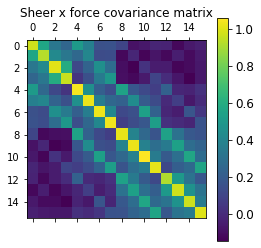

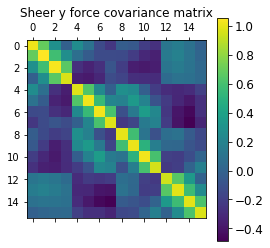

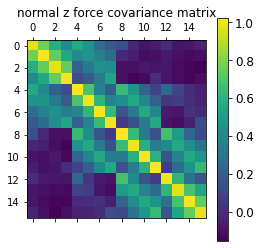

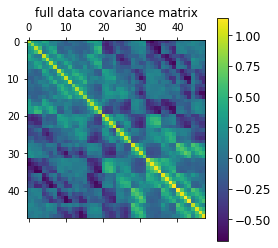

In [4]:
import matplotlib.pyplot as plt

pca_x = PCA(n_components=8)
pca_x.fit(xela_sensor1_data_x_scaled)
cov_x = pca_x.get_covariance()
plt.matshow(cov_x)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title("Sheer x force covariance matrix")
plt.show()

pca_y = PCA(n_components=8)
pca_y.fit(xela_sensor1_data_y_scaled)
cov_y = pca_y.get_covariance()
plt.matshow(cov_y)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title("Sheer y force covariance matrix")
plt.show()

pca_z = PCA(n_components=8)
pca_z.fit(xela_sensor1_data_z_scaled)
cov_z = pca_z.get_covariance()
plt.matshow(cov_z)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title("normal z force covariance matrix")
plt.show()

pca = PCA(n_components=8)
pca.fit(xela_sensor1_data_scaled)
cov = pca.get_covariance()
plt.matshow(cov)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title("full data covariance matrix")
plt.show()

# fig, ax = plt.subplots()
# ax.matshow(cov, cmap='seismic')
# for (i, j), z in np.ndenumerate(cov):
#     ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
# plt.title("Sheer x force covariance matrix")
# plt.show()

(103404, 10)
(103404, 48)


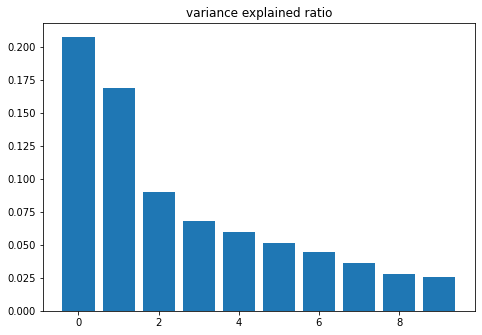

[617.52318121 570.48797315 440.34784072 351.84549923 343.70916385
 332.52494302 319.86901473 241.5035129 ]
[0.23048847 0.19671418 0.11720184 0.07482499 0.07140439 0.06683303
 0.0618425  0.03525247]


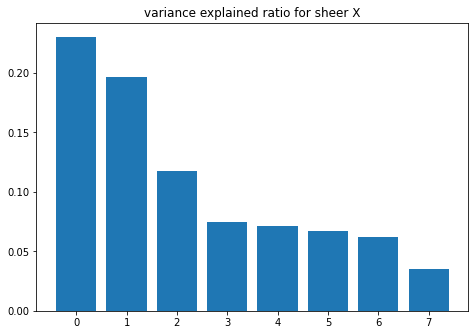

[690.90971219 644.33075229 471.69943678 400.81789756 317.58039214
 267.80521966 211.87755271 187.54264874]
[0.28852621 0.25093451 0.13448486 0.09710395 0.06096071 0.04334917
 0.02713392 0.021259  ]


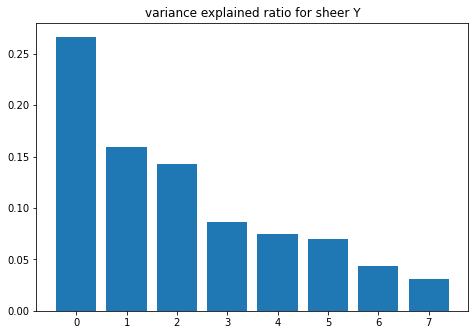

[690.90971219 644.33075229 471.69943678 400.81789756 317.58039214
 267.80521966 211.87755271 187.54264874]
[0.28852621 0.25093451 0.13448486 0.09710395 0.06096071 0.04334917
 0.02713392 0.021259  ]


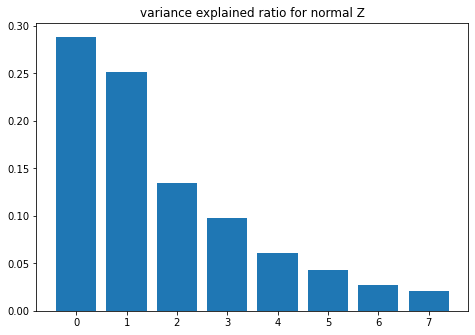

In [5]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(xela_sensor1_data_scaled)
pca.fit(xela_sensor1_data_scaled)
score = pca.score(xela_sensor1_data_scaled)
cov = pca.get_covariance()
xela_sensor1_principle_components = pca.transform(xela_sensor1_data_scaled)
inverse_transformed_data = pca.inverse_transform(xela_sensor1_principle_components)

print(xela_sensor1_principle_components.shape)
print(inverse_transformed_data.shape)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
feature = [i for i in range(len(pca.explained_variance_ratio_))]
variance_explained = pca.explained_variance_ratio_
ax.bar(feature,variance_explained)
plt.title("variance explained ratio")
plt.show()

print(pca_x.singular_values_)
print(pca_x.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
feature = [i for i in range(len(pca_x.explained_variance_ratio_))]
variance_explained = pca_x.explained_variance_ratio_
ax.bar(feature,variance_explained)
plt.title("variance explained ratio for sheer X")
plt.show()

print(pca_z.singular_values_)
print(pca_z.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
feature = [i for i in range(len(pca_y.explained_variance_ratio_))]
variance_explained = pca_y.explained_variance_ratio_
ax.bar(feature,variance_explained)
plt.title("variance explained ratio for sheer Y")
plt.show()

print(pca_z.singular_values_)
print(pca_z.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
feature = [i for i in range(len(pca_z.explained_variance_ratio_))]
variance_explained = pca_z.explained_variance_ratio_
ax.bar(feature,variance_explained)
plt.title("variance explained ratio for normal Z")
plt.show()

In [6]:
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 50
batch_size = 32
learning_rate = 1e-3
context_frames = 10
sequence_length = 20
lookback = sequence_length

context_epochs = 20
context_batch_size = 1
context_learning_rate = 1e-3
context_data_length = 20

valid_train_split = 0.8  # precentage of train data from total
test_train_split = 0.9  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_001/"
################################# CHANGE THIS!!!!  #################################

In [7]:
# scale between 0 and 1:

ee_position_x_final = np.array(ee_position_x_final) 
ee_position_y_final = np.array(ee_position_y_final) 
ee_position_z_final = np.array(ee_position_z_final) 
ee_orientation_quat_x_final = np.array(ee_orientation_quat_x_final) 
ee_orientation_quat_y_final = np.array(ee_orientation_quat_y_final) 
ee_orientation_quat_z_final = np.array(ee_orientation_quat_z_final) 
ee_orientation_quat_w_final = np.array(ee_orientation_quat_w_final) 
ee_orientation_x_final = np.array(ee_orientation_x_final) 
ee_orientation_y_final = np.array(ee_orientation_y_final) 
ee_orientation_z_final = np.array(ee_orientation_z_final) 
xela_sensor1_principle_components = np.array(xela_sensor1_principle_components) 


min_max_scaler_ee_position_x_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_position_x_final.reshape(-1, 1))
ee_position_x_final_scaled = min_max_scaler_ee_position_x_final.transform(ee_position_x_final.reshape(-1, 1))

min_max_scaler_ee_position_y_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_position_y_final.reshape(-1, 1))
ee_position_y_final_scaled = min_max_scaler_ee_position_y_final.transform(ee_position_y_final.reshape(-1, 1))

min_max_scaler_ee_position_z_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_position_z_final.reshape(-1, 1))
ee_position_z_final_scaled = min_max_scaler_ee_position_z_final.transform(ee_position_z_final.reshape(-1, 1))

min_max_scaler_ee_orientation_quat_x_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_x_final)
ee_orientation_quat_x_final_scaled = min_max_scaler_ee_orientation_quat_x_final.transform(ee_orientation_quat_x_final)

min_max_scaler_ee_orientation_quat_y_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_y_final)
ee_orientation_quat_y_final_scaled = min_max_scaler_ee_orientation_quat_y_final.transform(ee_orientation_quat_y_final)

min_max_scaler_ee_orientation_quat_z_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_z_final)
ee_orientation_quat_z_final_scaled = min_max_scaler_ee_orientation_quat_z_final.transform(ee_orientation_quat_z_final)

min_max_scaler_ee_orientation_quat_w_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_w_final)
ee_orientation_quat_w_final_scaled = min_max_scaler_ee_orientation_quat_w_final.transform(ee_orientation_quat_w_final)

min_max_scaler_ee_orientation_x_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_x_final.reshape(-1, 1))
ee_orientation_x_final_scaled = min_max_scaler_ee_orientation_x_final.transform(ee_orientation_x_final.reshape(-1, 1))

min_max_scaler_ee_orientation_y_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_y_final.reshape(-1, 1))
ee_orientation_y_final_scaled = min_max_scaler_ee_orientation_y_final.transform(ee_orientation_y_final.reshape(-1, 1))

min_max_scaler_ee_orientation_z_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_z_final.reshape(-1, 1))
ee_orientation_z_final_scaled = min_max_scaler_ee_orientation_z_final.transform(ee_orientation_z_final.reshape(-1, 1))

min_max_scaler_xela_sensor1_principle_components = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xela_sensor1_principle_components)
xela_sensor1_principle_components_scaled = min_max_scaler_xela_sensor1_principle_components.transform(xela_sensor1_principle_components)

# Convert data back into split experiments to create the sequences:
ee_position_x_final_split = np.asarray(np.split(ee_position_x_final_scaled, exp_break_points)[0:-1])
ee_position_y_final_split = np.asarray(np.split(ee_position_y_final_scaled, exp_break_points)[0:-1])
ee_position_z_final_split = np.asarray(np.split(ee_position_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_x_final_split = np.asarray(np.split(ee_orientation_quat_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_y_final_split = np.asarray(np.split(ee_orientation_quat_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_z_final_split = np.asarray(np.split(ee_orientation_quat_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_w_final_split = np.asarray(np.split(ee_orientation_quat_w_final_scaled, exp_break_points)[0:-1])
ee_orientation_x_final_split = np.asarray(np.split(ee_orientation_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_y_final_split = np.asarray(np.split(ee_orientation_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_z_final_split = np.asarray(np.split(ee_orientation_z_final_scaled, exp_break_points)[0:-1])
xela_sensor1_principle_components_split = np.asarray(np.split(xela_sensor1_principle_components_scaled, exp_break_points)[0:-1])

# Shuffle data:
p = np.random.permutation(len(ee_position_x_final_split))
print(p)
ee_position_x_final_split = ee_position_x_final_split[p]
ee_position_y_final_split = ee_position_y_final_split[p]
ee_position_z_final_split = ee_position_z_final_split[p]
ee_orientation_quat_x_final_split = ee_orientation_quat_x_final_split[p]
ee_orientation_quat_y_final_split = ee_orientation_quat_y_final_split[p]
ee_orientation_quat_z_final_split = ee_orientation_quat_z_final_split[p]
ee_orientation_quat_w_final_split = ee_orientation_quat_w_final_split[p]
ee_orientation_x_final_split = ee_orientation_x_final_split[p]
ee_orientation_y_final_split = ee_orientation_y_final_split[p]
ee_orientation_z_final_split = ee_orientation_z_final_split[p]
xela_sensor1_principle_components_split = xela_sensor1_principle_components_split[p]

[ 21   1 110  79  35  74  70  75  32  60  33  68  94  81  49  23  73  38
 107  42  13  64  61  43  25  99 106  62  84  53 103  30 113  96  36  47
  40  82  89  34   9  17   5  20  27   0 111  46  63  85  48  92   2  98
  55  87  77   4  91  50  51  28  22  45   6  26  10  69  88  65   8  44
  16 109  41  86  31  37  19   3  67 117 115  66  18  54 116 108 100  78
  56  97  80   7  72 105  57  29  11 114  58  59 102  39  93  52  83  12
  71 104  15  24 112  95  90 101  14  76 118]


In [8]:
# convert to sequences:
robot_data_euler_sequence, robot_data_quat_sequence, xela_1_sequence_data, experiment_data_sequence, time_step_data_sequence = [], [], [], [], []
for experiment in range(len(ee_position_x_final_split)):
    for sample in range(0, len(ee_position_x_final_split[experiment]) - sequence_length):
        robot_data_euler_sample, robot_data_quat_sample, xela_1_sequ_sample, experiment_data_sample, time_step_data_sample = [], [], [], [], []
        for t in range(0, sequence_length):
            robot_data_euler_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_x_final_split[experiment][sample+t], ee_orientation_y_final_split[experiment][sample+t], ee_orientation_z_final_split[experiment][sample+t]])
            robot_data_quat_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_quat_x_final_split[experiment][sample+t][0], ee_orientation_quat_y_final_split[experiment][sample+t][0], ee_orientation_quat_z_final_split[experiment][sample+t][0], ee_orientation_quat_w_final_split[experiment][sample+t][0]])
            xela_1_sequ_sample.append(xela_sensor1_principle_components_split[experiment][sample+t])
            experiment_data_sample.append(experiment)
            time_step_data_sample.append(sample+t)
        robot_data_euler_sequence.append(robot_data_euler_sample)
        robot_data_quat_sequence.append(robot_data_quat_sample)
        xela_1_sequence_data.append(xela_1_sequ_sample)
        experiment_data_sequence.append(experiment_data_sample)
        time_step_data_sequence.append(time_step_data_sample)

In [20]:
class BatchGenerator:
    def __init__(self):
        pass

    def load_full_data(self):
        dataset_train = FullDataSet(type_="train")
        dataset_valid = FullDataSet(type_="valid")
        dataset_test = FullDataSet(type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader


class FullDataSet():
    def __init__(self, type_="train"):
        if type_ == "train":
            self.samples = [0, int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "valid":
            self.samples = [int(len(robot_data_euler_sequence)*(valid_train_split)), int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "test":
            self.samples = [int(len(robot_data_euler_sequence)*test_train_split), len(robot_data_euler_sequence)]

    def __len__(self):
        return self.samples[1] - self.samples[0]

    def __getitem__(self,idx):
#         robot_euler = robot_data_euler_sequence[self.samples[0] + idx]
        robot_quat = robot_data_quat_sequence[self.samples[0] + idx]
        xela1 = xela_1_sequence_data[self.samples[0] + idx]
        experiment = experiment_data_sequence[self.samples[0] + idx]
        time_step  = time_step_data_sequence[self.samples[0] + idx]
        return([np.array(robot_quat).astype(np.float32),
                 np.array(xela1).astype(np.float32),
                 np.array(experiment),
                 np.array(time_step)])

In [25]:
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(10, 100).to(device)  # tactile
        self.lstm2 = nn.LSTM(7, 100).to(device)  # pos_vel
        self.fc1 = nn.Linear(200, 10)  # tactile + pos_vel
#         self.lstm3 = nn.LSTM(10, 10).to(device)  # pos_vel

    def forward(self, tactiles, actions):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.rand(1,batch_size__,100).to(device), torch.rand(1,batch_size__,100).to(device))
        hidden2 = (torch.rand(1,batch_size__,100).to(device), torch.rand(1,batch_size__,100).to(device))
        for index, (sample_tactile, sample_action) in enumerate(zip(tactiles.squeeze(), actions.squeeze())):
            sample_tactile.to(device)
            sample_action.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                out1, hidden1 = self.lstm1(out3.to(device), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                outputs.append(out3.squeeze())
            else:
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())

        return torch.stack(outputs)

In [26]:
class ModelTrainer:
    def __init__(self):
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.criterion1 = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 1.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0.0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                action = batch_features[0].permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,2).to(device)

                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions.to(device), tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    action = batch_features[0].permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,2).to(device)

                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action)  # Step 3. Run our forward pass.
                    self.optimizer.zero_grad()
                    val_loss = self.criterion1(tactile_predictions.to(device), tactile[context_frames:])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                previous_val_mean_loss = val_losses / index__ 
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                self.strongest_model = copy.deepcopy(self.full_model)
                early_stop_clock = 0
                previous_val_mean_loss = val_losses / index__ 
        plt.plot(plot_training_loss, c="r", label="train loss MAE")
        plt.plot(plot_validation_loss, c='b', label="val loss MAE")
        plt.legend(loc="upper right")
        plt.show()
        np.save(model_path + 'pca_training_loss', np.asarray(plot_training_loss))
        np.save(model_path + 'pca_validation_loss', np.asarray(plot_validation_loss))

In [27]:
BG = BatchGenerator()
print("done")

done


epoch: 1, loss: 0.0523, mean loss: 0.0519, :   2%|▏         | 2856/142100 [00:39<3:22:56, 11.44it/s]

Validation mean loss: 0.0439, 


epoch: 2, loss: 0.0385, mean loss: 0.0393, :   4%|▍         | 5697/142100 [01:18<3:15:00, 11.66it/s]

Validation mean loss: 0.0356, 


epoch: 3, loss: 0.0307, mean loss: 0.0336, :   6%|▌         | 8539/142100 [01:57<4:21:36,  8.51it/s]

Validation mean loss: 0.0310, 


epoch: 4, loss: 0.0331, mean loss: 0.0310, :   8%|▊         | 11382/142100 [02:37<3:06:26, 11.69it/s]

Validation mean loss: 0.0280, 


epoch: 5, loss: 0.0227, mean loss: 0.0298, :  10%|█         | 14224/142100 [03:16<3:05:14, 11.50it/s]

Validation mean loss: 0.0277, 


epoch: 6, loss: 0.0192, mean loss: 0.0285, :  12%|█▏        | 17066/142100 [03:55<3:01:45, 11.47it/s]

Validation mean loss: 0.0270, 


epoch: 7, loss: 0.0223, mean loss: 0.0304, :  14%|█▍        | 19907/142100 [04:35<2:52:59, 11.77it/s]

Validation mean loss: 0.0286, 


epoch: 8, loss: 0.0281, mean loss: 0.0304, :  16%|█▌        | 22757/142100 [05:14<2:43:37, 12.16it/s]

Validation mean loss: 0.0275, 


epoch: 9, loss: 0.0358, mean loss: 0.0330, :  18%|█▊        | 25599/142100 [05:53<2:48:39, 11.51it/s]

Validation mean loss: 0.0280, 


epoch: 10, loss: 0.0275, mean loss: 0.0295, :  20%|██        | 28442/142100 [06:33<2:42:22, 11.67it/s]

Validation mean loss: 0.0273, 


epoch: 11, loss: 0.0224, mean loss: 0.0293, :  22%|██▏       | 31284/142100 [07:12<2:40:10, 11.53it/s]

Validation mean loss: 0.0281, 


epoch: 12, loss: 0.0266, mean loss: 0.0316, :  24%|██▍       | 34126/142100 [07:51<2:38:57, 11.32it/s]

Validation mean loss: 0.0271, 


epoch: 13, loss: 0.0256, mean loss: 0.0292, :  26%|██▌       | 36968/142100 [08:30<2:29:43, 11.70it/s]

Validation mean loss: 0.0266, 


epoch: 14, loss: 0.0345, mean loss: 0.0305, :  28%|██▊       | 39810/142100 [09:09<2:28:05, 11.51it/s]

Validation mean loss: 0.0271, 


epoch: 15, loss: 0.0293, mean loss: 0.0300, :  30%|███       | 42652/142100 [09:48<2:20:48, 11.77it/s]

Validation mean loss: 0.0269, 


epoch: 16, loss: 0.0364, mean loss: 0.0302, :  32%|███▏      | 45494/142100 [10:26<2:13:33, 12.06it/s]

Validation mean loss: 0.0283, 


epoch: 17, loss: 0.0237, mean loss: 0.0301, :  34%|███▍      | 48335/142100 [11:05<2:11:09, 11.91it/s]

Validation mean loss: 0.0274, 


epoch: 18, loss: 0.0219, mean loss: 0.0293, :  36%|███▌      | 51178/142100 [11:44<2:04:45, 12.15it/s]

Validation mean loss: 0.0279, 


epoch: 19, loss: 0.0255, mean loss: 0.0290, :  38%|███▊      | 54020/142100 [12:23<2:06:06, 11.64it/s]

Validation mean loss: 0.0272, 


epoch: 20, loss: 0.0289, mean loss: 0.0297, :  40%|████      | 56862/142100 [13:01<2:01:26, 11.70it/s]

Validation mean loss: 0.0280, 


epoch: 21, loss: 0.0243, mean loss: 0.0324, :  42%|████▏     | 59704/142100 [13:40<1:57:47, 11.66it/s]

Validation mean loss: 0.0277, 


epoch: 22, loss: 0.0244, mean loss: 0.0313, :  44%|████▍     | 62546/142100 [14:19<1:55:24, 11.49it/s]

Validation mean loss: 0.0266, 


epoch: 23, loss: 0.0206, mean loss: 0.0271, :  46%|████▌     | 65387/142100 [14:58<2:21:57,  9.01it/s]

Validation mean loss: 0.0264, 


epoch: 24, loss: 0.0224, mean loss: 0.0283, :  48%|████▊     | 68230/142100 [15:37<1:46:24, 11.57it/s]

Validation mean loss: 0.0270, 


epoch: 25, loss: 0.0208, mean loss: 0.0298, :  50%|█████     | 71072/142100 [16:16<1:41:51, 11.62it/s]

Validation mean loss: 0.0271, 


epoch: 26, loss: 0.0219, mean loss: 0.0302, :  52%|█████▏    | 73914/142100 [16:55<1:38:15, 11.57it/s]

Validation mean loss: 0.0258, 


epoch: 27, loss: 0.0281, mean loss: 0.0290, :  54%|█████▍    | 76755/142100 [17:34<1:33:13, 11.68it/s]

Validation mean loss: 0.0261, 


epoch: 28, loss: 0.0268, mean loss: 0.0299, :  56%|█████▌    | 79599/142100 [18:13<1:29:57, 11.58it/s]

Validation mean loss: 0.0263, 


epoch: 28, loss: 0.0252, mean loss: 0.0272, :   0%|          | 28/142100 [18:52<1595:34:24, 40.43s/it]

Validation mean loss: 0.0264, 
Early stopping


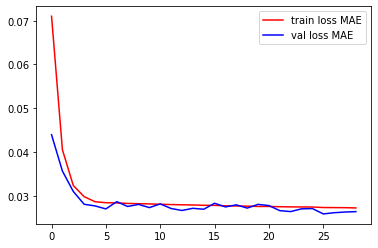

finished training
saved the model


In [28]:
MT = ModelTrainer()
MT.train_full_model()
print("finished training")
torch.save(MT.strongest_model, model_path + "pca_full_model")
model = torch.load(model_path + "pca_full_model")
model.eval()
print("saved the model")

In [ ]:
# test model on the full test sample:
# model = MT.strongest_model

criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()

test_lossesMAE_t1 = 0.0
test_lossesMSE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMSE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMSE_t10 = 0.0

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(MT.test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)

        tp = model.forward(tactiles=tactile, actions=action)
        experiment_time_steps.append([batch_features[2], batch_features[3]])
        tactile_predictions.append(tp)  # Step 3. Run our forward pass.
        tactile_groundtruth.append(tactile[context_frames:])
        # calculate losses for specific timesteps
        test_lossMAE_t1 = criterion1(tp[0,:,:].to(device), tactile[context_frames:][0,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item()
        test_lossMSE_t1 = criterion2(tp[0,:,:].to(device), tactile[context_frames:][0,:,:])
        test_lossesMSE_t1 += test_lossMSE_t1.item()
        test_lossMAE_t5 = criterion1(tp[4,:,:].to(device), tactile[context_frames:][4,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item()
        test_lossMSE_t5 = criterion2(tp[4,:,:].to(device), tactile[context_frames:][4,:,:])
        test_lossesMSE_t5 += test_lossMSE_t5.item()
        test_lossMAE_t10 = criterion1(tp[5,:,:].to(device), tactile[context_frames:][5,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item()
        test_lossMSE_t10 = criterion2(tp[5,:,:].to(device), tactile[context_frames:][5,:,:])
        test_lossesMSE_t10 += test_lossMSE_t10.item()

#         # calculate losses for specific forces
#         test_lossMAE_x = criterion1(tp[:,:,:16].to(device), tactile[context_frames:][:,:,:16])
#         test_lossesMAE_x += test_lossMAE_x.item() 
#         test_lossMSE_x = criterion2(tp[:,:,:16].to(device), tactile[context_frames:][:,:,:16])
#         test_lossesMSE_x += test_lossMSE_x.item() 
#         test_lossMAE_y = criterion1(tp[:,:,17:32].to(device), tactile[context_frames:][:,:,17:32])
#         test_lossesMAE_y += test_lossMAE_y.item() 
#         test_lossMSE_y = criterion2(tp[:,:,17:32].to(device), tactile[context_frames:][:,:,17:32])
#         test_lossesMSE_y += test_lossMSE_y.item() 
#         test_lossMAE_z = criterion1(tp[:,:,33:48].to(device), tactile[context_frames:][:,:,33:48])
#         test_lossesMAE_z += test_lossMAE_z.item() 
#         test_lossMSE_z = criterion2(tp[:,:,33:48].to(device), tactile[context_frames:][:,:,33:48])
#         test_lossesMSE_z += test_lossMSE_z.item() 

#         # calculate losses for specific timesteps and forces 
#         test_lossMAE_x_ts1 = criterion1(tp[0,:,:16].to(device), tactile[context_frames:][0,:,:16])
#         test_lossesMAE_x_ts1 += test_lossMAE_x_ts1.item() 
#         test_lossMSE_x_ts1 = criterion2(tp[0,:,:16].to(device), tactile[context_frames:][0,:,:16])
#         test_lossesMSE_x_ts1 += test_lossMSE_x_ts1.item() 
#         test_lossMAE_y_ts1 = criterion1(tp[0,:,17:32].to(device), tactile[context_frames:][0,:,17:32])
#         test_lossesMAE_y_ts1 += test_lossMAE_y_ts1.item() 
#         test_lossMSE_y_ts1 = criterion2(tp[0,:,17:32].to(device), tactile[context_frames:][0,:,17:32])
#         test_lossesMSE_y_ts1 += test_lossMSE_y_ts1.item() 
#         test_lossMAE_z_ts1 = criterion1(tp[0,:,33:48].to(device), tactile[context_frames:][0,:,33:48])
#         test_lossesMAE_z_ts1 += test_lossMAE_z_ts1.item() 
#         test_lossMSE_z_ts1 = criterion2(tp[0,:,33:48].to(device), tactile[context_frames:][0,:,33:48])
#         test_lossesMSE_z_ts1 += test_lossMSE_z_ts1.item() 
 
#         test_lossMAE_x_ts5 = criterion1(tp[4,:,:16].to(device), tactile[context_frames:][4,:,:16])
#         test_lossesMAE_x_ts5 += test_lossMAE_x_ts5.item() 
#         test_lossMSE_x_ts5 = criterion2(tp[4,:,:16].to(device), tactile[context_frames:][4,:,:16])
#         test_lossesMSE_x_ts5 += test_lossMSE_x_ts5.item() 
#         test_lossMAE_y_ts5 = criterion1(tp[4,:,17:32].to(device), tactile[context_frames:][4,:,17:32])
#         test_lossesMAE_y_ts5 += test_lossMAE_y_ts5.item() 
#         test_lossMSE_y_ts5 = criterion2(tp[4,:,17:32].to(device), tactile[context_frames:][4,:,17:32])
#         test_lossesMSE_y_ts5 += test_lossMSE_y_ts5.item() 
#         test_lossMAE_z_ts5 = criterion1(tp[4,:,33:48].to(device), tactile[context_frames:][4,:,33:48])
#         test_lossesMAE_z_ts5 += test_lossMAE_z_ts5.item() 
#         test_lossMSE_z_ts5 = criterion2(tp[4,:,33:48].to(device), tactile[context_frames:][4,:,33:48])
#         test_lossesMSE_z_ts5 += test_lossMSE_z_ts5.item() 

#         test_lossMAE_x_ts10 = criterion1(tp[5,:,:16].to(device), tactile[context_frames:][5,:,:16])
#         test_lossesMAE_x_ts10 += test_lossMAE_x_ts10.item() 
#         test_lossMSE_x_ts10 = criterion2(tp[5,:,:16].to(device), tactile[context_frames:][5,:,:16])
#         test_lossesMSE_x_ts10 += test_lossMSE_x_ts10.item() 
#         test_lossMAE_y_ts10 = criterion1(tp[5,:,17:32].to(device), tactile[context_frames:][5,:,17:32])
#         test_lossesMAE_y_ts10 += test_lossMAE_y_ts10.item() 
#         test_lossMSE_y_ts10 = criterion2(tp[5,:,17:32].to(device), tactile[context_frames:][5,:,17:32])
#         test_lossesMSE_y_ts10 += test_lossMSE_y_ts10.item() 
#         test_lossMAE_z_ts10 = criterion1(tp[5,:,33:48].to(device), tactile[context_frames:][5,:,33:48])
#         test_lossesMAE_z_ts10 += test_lossMAE_z_ts10.item() 
#         test_lossMSE_z_ts10 = criterion2(tp[5,:,33:48].to(device), tactile[context_frames:][5,:,33:48])
#         test_lossesMSE_z_ts10 += test_lossMSE_z_ts10.item()

performance_data = []

performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MSE: ", (test_lossesMSE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_t1 / index__)])
performance_data.append(["test loss MSE timestep 1: ", (test_lossesMSE_t1 / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_t5 / index__)])
performance_data.append(["test loss MSE timestep 5: ", (test_lossesMSE_t5 / index__)])
performance_data.append(["test loss MAE(L1) timestep 6: ", (test_lossesMAE_t10 / index__)])
performance_data.append(["test loss MSE timestep 6: ", (test_lossesMSE_t10 / index__)])


# performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
# performance_data.append(["test loss MSE: ", (test_lossesMSE / index__)])
# performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_x / index__)])
# performance_data.append(["test loss MSE timestep 1: ", (test_lossesMSE_x / index__)])
# performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_y / index__)])
# performance_data.append(["test loss MSE timestep 5: ", (test_lossesMSE_y / index__)])
# performance_data.append(["test loss MAE(L1) timestep 6: ", (test_lossesMAE_z / index__)])
# performance_data.append(["test loss MSE timestep 6: ", (test_lossesMSE_z / index__)])
# performance_data.append(["sheer x test loss MAE(L1): ", (test_lossesMAE_x / index__)])
# performance_data.append(["sheer x test loss MSE: ", (test_lossesMSE_x / index__)])
# performance_data.append(["sheer y test loss MAE(L1): ", (test_lossesMAE_y / index__)])
# performance_data.append(["sheer y test loss MSE: ", (test_lossesMSE_y / index__)])
# performance_data.append(["z test loss MAE(L1): ", (test_lossesMAE_z / index__)])
# performance_data.append(["z test loss MSE: ", (test_lossesMSE_z / index__)])
# performance_data.append(["sheer x test loss MAE(L1) timestep 1: ", (test_lossesMAE_x_ts1 / index__)])
# performance_data.append(["sheer x test loss MSE timestep 1: ", (test_lossesMSE_x_ts1 / index__)])
# performance_data.append(["sheer y test loss MAE(L1) timestep 1: ", (test_lossesMAE_y_ts1 / index__)])
# performance_data.append(["sheer y test loss MSE timestep 1: ", (test_lossesMSE_y_ts1 / index__)])
# performance_data.append(["z test loss MAE(L1) timestep 1: ", (test_lossesMAE_z_ts1 / index__)])
# performance_data.append(["z test loss MSE timestep 1: ", (test_lossesMSE_z_ts1 / index__)])
# performance_data.append(["sheer x test loss MAE(L1) timestep 5: ", (test_lossesMAE_x_ts5 / index__)])
# performance_data.append(["sheer x test loss MSE timestep 5: ", (test_lossesMSE_x_ts5 / index__)])
# performance_data.append(["sheer y test loss MAE(L1) timestep 5: ", (test_lossesMAE_y_ts5 / index__)])
# performance_data.append(["sheer y test loss MSE timestep 5: ", (test_lossesMSE_y_ts5 / index__)])
# performance_data.append(["z test loss MAE(L1) timestep 5: ", (test_lossesMAE_z_ts5 / index__)])
# performance_data.append(["z test loss MSE timestep 5: ", (test_lossesMSE_z_ts5 / index__)])
# performance_data.append(["sheer x test loss MAE(L1) timestep 6: ", (test_lossesMAE_x_ts10 / index__)])
# performance_data.append(["sheer x test loss MSE timestep 6: ", (test_lossesMSE_x_ts10 / index__)])
# performance_data.append(["sheer y test loss MAE(L1) timestep 6: ", (test_lossesMAE_y_ts10 / index__)])
# performance_data.append(["sheer y test loss MSE timestep 6: ", (test_lossesMSE_y_ts10 / index__)])
# performance_data.append(["z test loss MAE(L1) timestep 6: ", (test_lossesMAE_z_ts10 / index__)])
# performance_data.append(["z test loss MSE timestep 6: ", (test_lossesMSE_z_ts10 / index__)])
[print(i) for i in performance_data]

np.save(model_path + 'pca_performance_data', np.asarray(performance_data))

# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t9 = 5
predicted_data_t1 = []
predicted_data_t9 = []
groundtruth_data = []
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        prediction_values = batch_set[time_step_to_test_t1][batch]
        predicted_data_t1.append(prediction_values)
        prediction_values = batch_set[time_step_to_test_t9][batch]
        predicted_data_t9.append(prediction_values)
        gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
        groundtruth_data.append(gt_values)  
print("done")

In [ ]:
print(predicted_data_t1[100])
print(groundtruth_data[100])

In [ ]:
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
experiment_to_test = 106
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        experiment = experiment_time_steps[index][0][batch]
        if experiment == experiment_to_test:
            prediction_values = batch_set[time_step_to_test_t1][batch]
            predicted_data_t1.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t5][batch]
            predicted_data_t5.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t9][batch]
            predicted_data_t9.append(prediction_values)
            gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
            groundtruth_data.append(gt_values)

# print(tactile_predictions[0])
# plt.plot([i for i in range(len(tactile_predictions[0]))], [i for i in range(len(tactile_predictions[0]))])
plt.show()        
mse_loss = torch.nn.MSELoss()
# print("MAE timestep + 1: ", np.mean(np.asarray([mse_loss(np.asarray(pred.cpu().detach()), np.asarray(gt.cpu().detach()))  for pred, gt in zip(predicted_data_t1, groundtruth_data)])))
# print("MAE timestep + 5: ", mse_loss(torch.tensor(predicted_data_t5), torch.tensor(groundtruth_data)))
# print("MAE timestep + 9: ", mse_loss(torch.tensor(predicted_data_t9), torch.tensor(groundtruth_data)))

# test data
index = 0
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        # good = 140, 145 (lifting up the )
        for k in range(len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][j+i].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][j+i].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][j+i].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][j+i].cpu().detach().numpy())

        index += 1
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t1, alpha=0.5, c="b", label="t1")
        ax1.plot(predicted_taxel_t5, alpha=0.5, c="k", label="t5")
        ax1.plot(predicted_taxel_t9, alpha=0.5, c="g", label="t10")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i], groundtruth_data[i]) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/pp_sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t1, alpha=0.5, c="b", label="t1")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i], groundtruth_data[i]) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/pp_T0sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t5, alpha=0.5, c="b", label="t5")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i], groundtruth_data[i]) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/pp_T5sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot(predicted_taxel_t9, alpha=0.5, c="b", label="t10")
        ax1.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('loss')  # we already handled the x-label with ax1
        ax2.plot([i for i in range(len(groundtruth_data))], [mse_loss(predicted_data_t9[i], groundtruth_data[i]) for i in range(len(groundtruth_data))], alpha=0.5)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Simple_LSTM tactile " + str(index))
        plt.savefig(model_path + '/' + str(experiment_to_test) + '/pp_T10sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()
    
#         plt.plot(predicted_taxel_t1, alpha=0.5, c="b", label="t0")
#         plt.plot(predicted_taxel_t5, alpha=0.5, c="k", label="t5")
#         plt.plot(predicted_taxel_t9, alpha=0.5, c="g", label="t9")
#         plt.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
#         plt.ylim([0, 1])
#         plt.grid()
#         plt.legend(loc="upper right")
#         plt.savefig('/home/user/Pictures/simple_model_001/simple_model_test_sample_' + str(index) + '.png')
#         plt.show()
    